In [7]:
# Load relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm

In [8]:
!pip install openpyxl


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


QUESTION 1

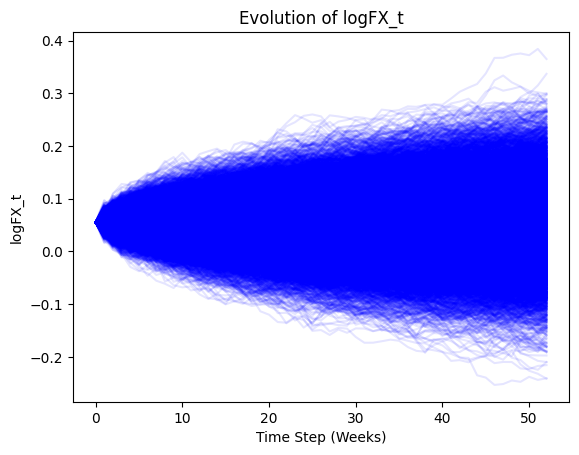

In [10]:
# Load data
covariance_matrix = pd.read_excel('covariance_matrix.xlsx', index_col=0)
init_values = pd.read_excel('init_values.xlsx', index_col=0)

# Parameters
mu = np.array([0, 0.07/52, 0.06/52] + [0] * (len(covariance_matrix) - 3))
sigma = covariance_matrix.values
initial_values = init_values.values.flatten()

# Simulation parameters
time_steps = 52  # Weekly time steps for one year
num_simulations = 10000 # Number of simulation paths
n_assets = len(initial_values)

# Simulate paths
paths = np.zeros((num_simulations, time_steps + 1, n_assets))
paths[:, 0, :] = initial_values

for t in range(1, time_steps + 1):
    delta_x = np.random.multivariate_normal(mu, sigma, size=num_simulations)
    paths[:, t, :] = paths[:, t-1, :] + delta_x

# Extract logFX_t and visualize
log_fx_t = paths[:, :, 0]  # Assuming logFX_t is the first variable
plt.plot(range(time_steps + 1), log_fx_t.T, alpha=0.1, color='blue')
plt.title("Evolution of logFX_t")
plt.xlabel("Time Step (Weeks)")
plt.ylabel("logFX_t")
plt.show()

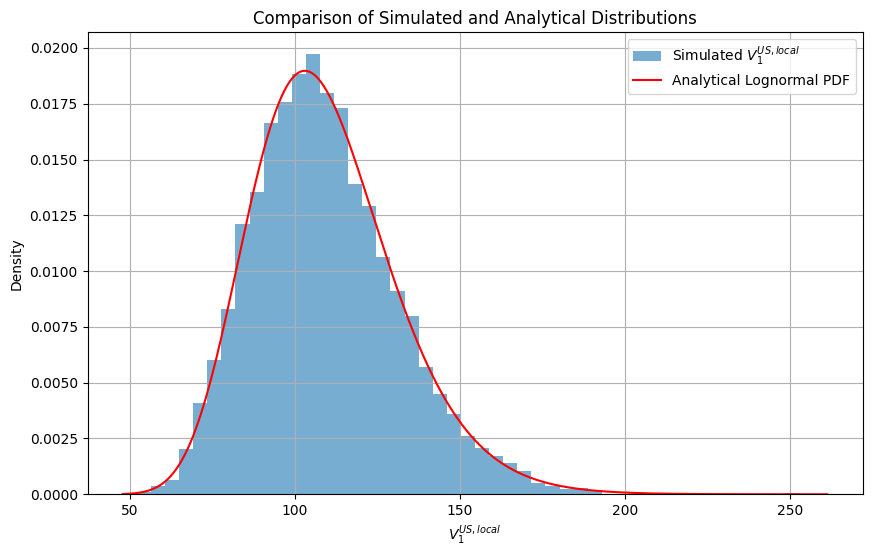

In [7]:
# Parameters
V_0 = 100  # Initial value of V^{US,local}
delta_t = 1 / 52  # Weekly time step
T = 1  # Time horizon (1 year)
n_steps = int(T / delta_t)  # Number of time steps
n_simulations = 10000  # Number of simulation paths

# Mean and variance for log V^{US,local}
mu_V = 0.07  # Annual growth rate for US equities
sigma_V2 = 0.04  # Variance of log V^{US,local}

# Analytical distribution parameters
mu_log_V = np.log(V_0) + mu_V * T
sigma_log_V = np.sqrt(sigma_V2 * T)

# Simulate evolution
np.random.seed(42)  # For reproducibility
log_V_t = np.full((n_simulations, 1), np.log(V_0))  # Initialize log V_0

# Simulate weekly steps
for _ in range(n_steps):
    delta_log_V = np.random.normal(mu_V * delta_t, np.sqrt(sigma_V2 * delta_t), size=(n_simulations, 1))
    log_V_t = np.hstack((log_V_t, log_V_t[:, -1:] + delta_log_V))

# Extract final values
V_1_simulated = np.exp(log_V_t[:, -1])

# Analytical PDF for comparison
x = np.linspace(min(V_1_simulated), max(V_1_simulated), 1000)
pdf = lognorm.pdf(x, s=sigma_log_V, scale=np.exp(mu_log_V))

# Plot histogram and analytical PDF
plt.figure(figsize=(10, 6))
plt.hist(V_1_simulated, bins=50, density=True, alpha=0.6, label='Simulated $V_1^{US,local}$')
plt.plot(x, pdf, label='Analytical Lognormal PDF', color='red')
plt.xlabel('$V_1^{US,local}$')
plt.ylabel('Density')
plt.title('Comparison of Simulated and Analytical Distributions')
plt.legend()
plt.grid()
plt.show()


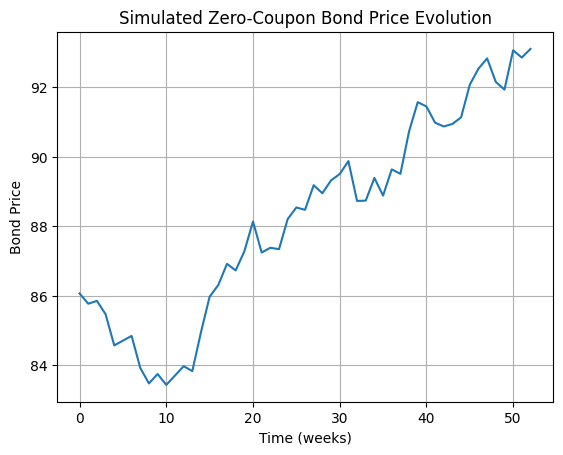

In [8]:
import numpy as np

# Parameters
face_value = 100
initial_yield = 0.03  # Example yield (3%)
volatility = 0.01     # Annual yield volatility (1%)
time_to_maturity = 5  # 5-year zero-coupon bond
time_steps = 52       # Weekly steps (1 year = 52 weeks)
dt = 1 / 52

# Simulate weekly yield evolution
np.random.seed(42)
yields = np.zeros(time_steps + 1)
yields[0] = initial_yield

for t in range(1, time_steps + 1):
    yields[t] = yields[t - 1] + np.random.normal(0, volatility * np.sqrt(dt))

# Calculate bond price at each time step
prices = face_value * np.exp(-yields * time_to_maturity)

# Visualize results
import matplotlib.pyplot as plt
plt.plot(range(time_steps + 1), prices)
plt.title("Simulated Zero-Coupon Bond Price Evolution")
plt.xlabel("Time (weeks)")
plt.ylabel("Bond Price")
plt.grid()
plt.show()


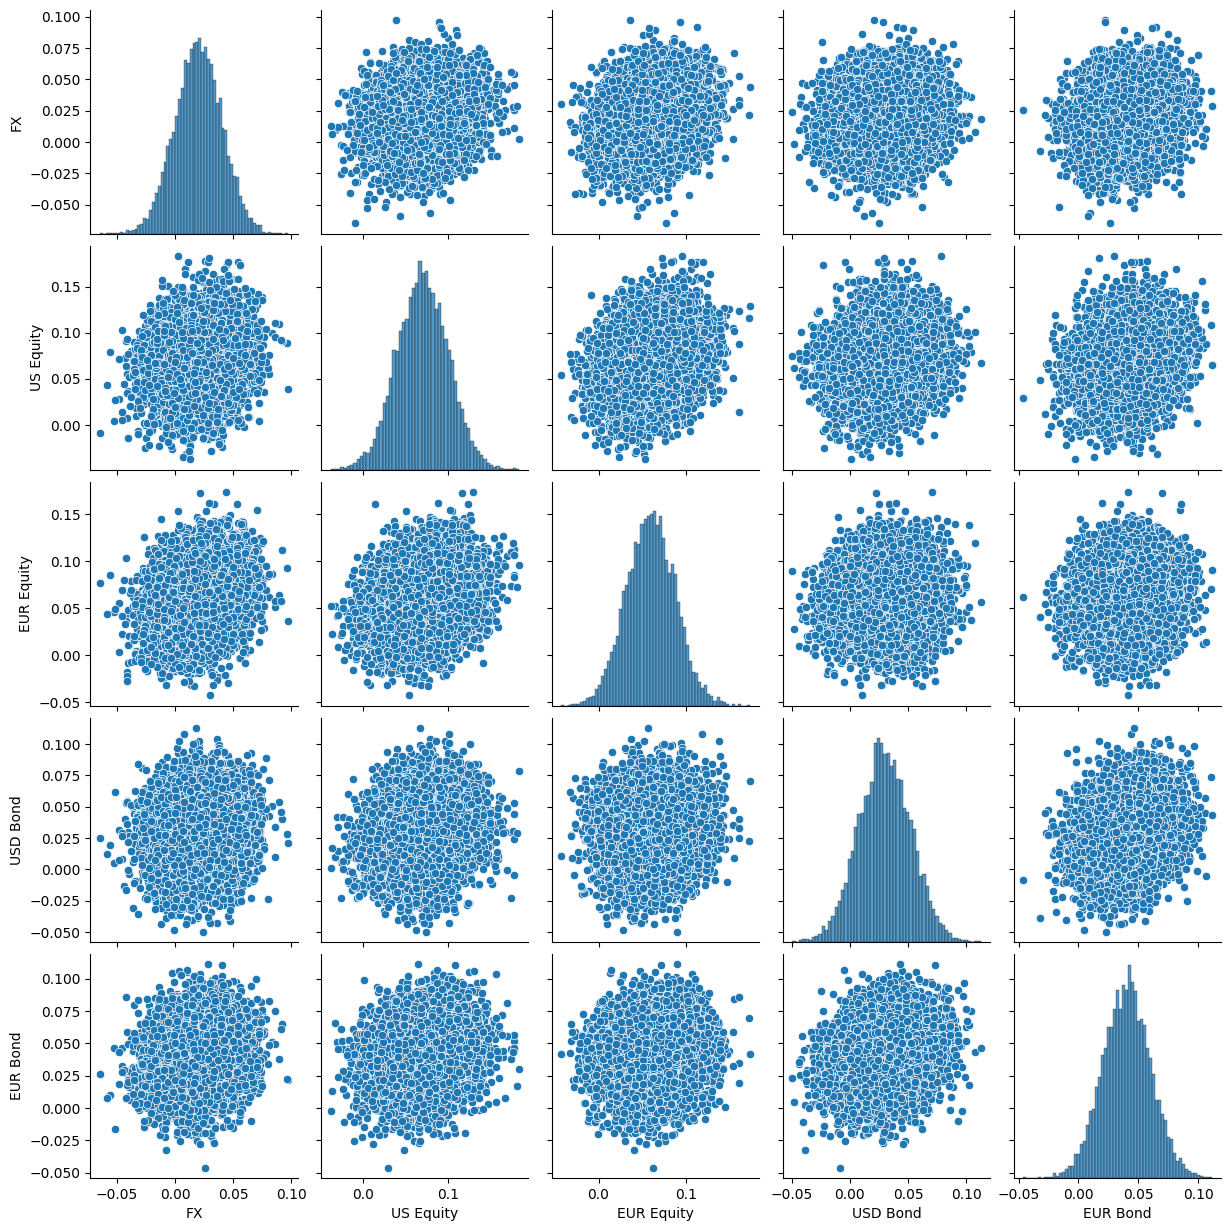

In [9]:
from scipy.stats import multivariate_normal

# Mean vector and covariance matrix (example values)
mean_vector = [0.02, 0.07, 0.06, 0.03, 0.04]  # FX, US equity, EUR equity, USD bond, EUR bond
cov_matrix = np.array([
    [0.0004, 0.0001, 0.0001, 0.00005, 0.00005],
    [0.0001, 0.0009, 0.0002, 0.0001, 0.0001],
    [0.0001, 0.0002, 0.0008, 0.00005, 0.00005],
    [0.00005, 0.0001, 0.00005, 0.0005, 0.0001],
    [0.00005, 0.0001, 0.00005, 0.0001, 0.0004]
])

# Simulate the joint distribution
n_simulations = 10000
simulated_data = np.random.multivariate_normal(mean_vector, cov_matrix, n_simulations)

# Visualize pairwise scatter plots
import seaborn as sns
sns.pairplot(pd.DataFrame(simulated_data, columns=['FX', 'US Equity', 'EUR Equity', 'USD Bond', 'EUR Bond']))
plt.show()


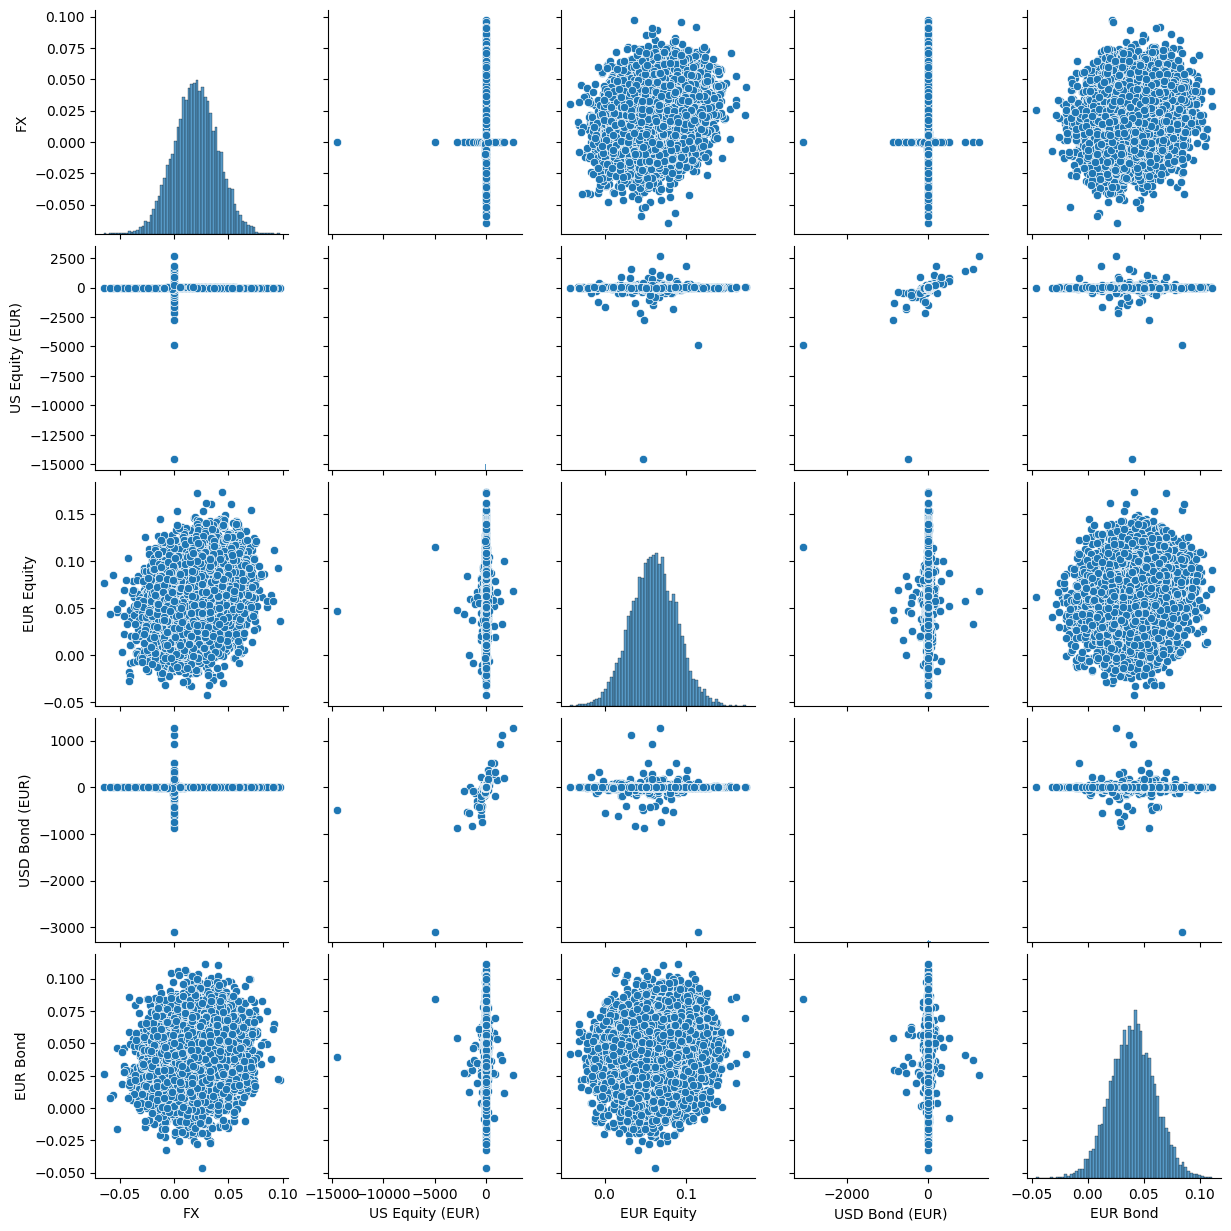

In [10]:
# Convert USD-based values to EUR
fx_values = simulated_data[:, 0]  # FX values (first column)
p1_eur = np.copy(simulated_data)  # Copy of the joint distribution data
p1_eur[:, 1] /= fx_values         # Convert US equity
p1_eur[:, 3] /= fx_values         # Convert USD bond

# Visualize transformed data
sns.pairplot(pd.DataFrame(p1_eur, columns=['FX', 'US Equity (EUR)', 'EUR Equity', 'USD Bond (EUR)', 'EUR Bond']))
plt.show()
